In [1]:
import pandas as pd
import re

import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 14:03:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/30 14:03:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
AAPL_stock = pd.read_csv("./dataset/stocks/AAPL.csv")
AAPL_stock = AAPL_stock.loc[:, ['time', 'close']]
AAPL_stock['time'] = pd.to_datetime(AAPL_stock['time'])

In [3]:
AAPL_stock.head()

,time,close
0,2022-10-31 04:00:00,153.34
1,2022-11-01 04:00:00,150.65
2,2022-11-02 04:00:00,145.03
3,2022-11-03 04:00:00,138.88
4,2022-11-04 04:00:00,138.38


In [4]:
AAPL_stock.dtypes

time     datetime64[ns]
close           float64
dtype: object

In [5]:
AAPL_sentiment = pd.read_csv("./data_combine/news_alpha/AAPL_relation.csv")


In [7]:
AAPL_sentiment.head()

,news_id,source_ticker,time,ticker,relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,NaN,AAPL,2023-01-01 05:13:00,BRK-A,0.112797,0.138191,Neutral
1,NaN,AAPL,2023-01-01 05:13:00,NFLX,0.056540,0.067098,Neutral
2,NaN,AAPL,2023-01-01 05:13:00,PARA,0.277118,0.222256,Somewhat-Bullish
3,NaN,AAPL,2023-01-01 05:13:00,AAPL,0.277118,0.187644,Somewhat-Bullish
4,NaN,AAPL,2023-01-01 05:30:00,GOOG,0.751437,0.466083,Bullish


In [8]:
AAPL_sentiment = AAPL_sentiment[AAPL_sentiment['ticker'] == 'AAPL']
AAPL_sentiment = AAPL_sentiment.loc[:, ['time', 'relevance_score', 'ticker_sentiment_score']]

In [9]:
AAPL_sentiment.head()

,time,relevance_score,ticker_sentiment_score
3,2023-01-01 05:13:00,0.277118,0.187644
6,2023-01-01 05:30:00,0.436009,0.357976
12,2023-01-01 05:50:00,0.178021,-0.066673
19,2023-01-02 02:20:29,0.065866,0.067368
23,2023-01-02 06:20:08,0.127795,0.066196


In [10]:
AAPL_sentiment.dtypes

time                       object
relevance_score           float64
ticker_sentiment_score    float64
dtype: object

In [11]:
df = pd.DataFrame(AAPL_sentiment)
df['time'] = pd.to_datetime(df['time'])

# Group by date and calculate weighted average for ticker_sentiment_score
df['date'] = df['time'].dt.date
df['weighted_score'] = df['relevance_score'] * df['ticker_sentiment_score']

df = df.groupby('date').apply(
    lambda x: pd.Series({
        'time': pd.Timestamp(f"{x['date'].iloc[0]} 04:00:00"),
        'sentiment_score': x['weighted_score'].sum() / x['relevance_score'].sum()
    })
).reset_index(drop=True)


/var/folders/gg/1hsbwd152mn3yjhz0h5qpwqh0000gn/T/ipykernel_34779/1963594051.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('date').apply(


In [12]:
df.head()

,time,sentiment_score
0,2023-01-01 04:00:00,0.220178
1,2023-01-02 04:00:00,0.063687
2,2023-01-04 04:00:00,0.018371
3,2023-01-05 04:00:00,0.007521
4,2023-02-02 04:00:00,0.053345


In [13]:
finalData = pd.merge(AAPL_stock, df, on='time')
finalData.columns = ["DateTime", 'Price', 'Sentiment_score']
finalData = finalData[['DateTime', 'Sentiment_score', 'Price']]

In [14]:
finalData.head()

,DateTime,Sentiment_score,Price
0,2024-09-30 04:00:00,-0.001331,233.00
1,2024-10-01 04:00:00,0.180773,226.21
2,2024-10-02 04:00:00,0.220477,226.78


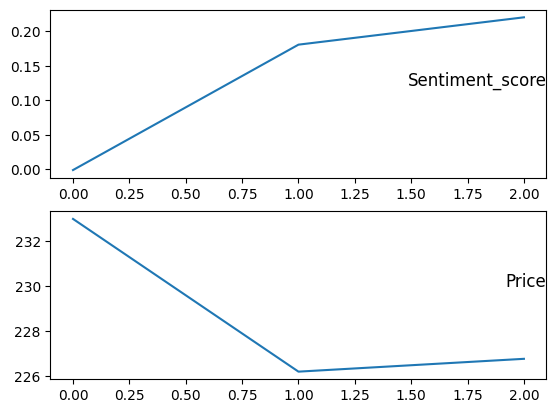

In [55]:
values = finalData.values
# specify columns to plot
groups = [1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(finalData.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [56]:
finalData.set_index('DateTime',inplace=True)  
cols = finalData.columns.tolist()
cols = cols[-1:] + cols[:-1]
finalData = finalData[cols]
finalData

,Price,Sentiment_score
DateTime,,
2024-09-30 04:00:00,233.00,-0.001331
2024-10-01 04:00:00,226.21,0.180773
2024-10-02 04:00:00,226.78,0.220477


In [15]:
def concat_df(df_train, df_test, time_col='time', time_split='2024-10-30'):
    df_train = df_train[df_train[time_col] < time_split]
    df_test = df_test[df_test[time_col] >= time_split]
    return pd.concat([df_train, df_test], axis=0, ignore_index=True)

def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

def prepare_data(ticker, stock_relation):
    stock_price1 = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price2 = pd.read_csv(f"../dataset/stocks/{ticker}_test.csv")
    stock_price = concat_df(stock_price1, stock_price2)
    
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    relation_t = stock_relation[stock_relation['ticker'] == ticker]
    relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
    relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
    relation_t['direct_sentiment'] = relation_t['sentiment']
    relation_t.loc[relation_t['same_source'] == 0, 'direct_sentiment'] = 'None'

    news_comb = pd.merge(relation_t, stock_price, how='left', left_on='news_date', right_on='trade_date')
    # news_comb['trade_date'] = news_comb['trade_date'].fillna(method='bfill')
    news_comb = news_comb.dropna(subset=['trade_date'])
    news_comb['direct_sentiment'] = news_comb['sentiment']
    news_comb.loc[news_comb['source_ticker'] != news_comb['ticker'], 'direct_sentiment'] = 'None'

    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first',
        'sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
        'direct_sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'positive', 'negative', 'dir_positive', 'dir_negative']
    return relation_gp

In [17]:
stock_relation1 = pd.read_csv("../dataset/news/relation_all.csv")
stock_relation2 = pd.read_csv("../dataset/news/relation_all_test.csv")
stock_relation = concat_df(stock_relation1, stock_relation2)
stock_relation['time'] = pd.to_datetime(stock_relation['time'])
stock_relation

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/news/relation_all.csv'

24/11/30 15:08:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 269602 ms exceeds timeout 120000 ms
24/11/30 15:08:15 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/30 15:08:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [16]:
relation_gp = prepare_data(ticker='META', stock_relation=stock_relation)

NameError: name 'stock_relation' is not defined